Nugroho Budianggoro, 01/02/2022

This script is to analyze human stampedes data by means of k-means clustering and two methods of topic modeling.

### K-means Clustering

In [1]:
# Imports

import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import names
nltk.download('names')

[nltk_data] Downloading package names to C:\Users\Nugroho
[nltk_data]     Budianggoro\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [2]:
# Get the dataset

url = "https://github.com/nugi1209/NadiData.com/raw/main/1225_dataset.csv"
df = pd.read_csv(url)
print(df.shape)
df.head()

(183, 7)


,Event ID,Event Name,Date,Number of Deaths,Country,Place,Description
0,1,1807 Newgate disaster,1807-02-23,30,United Kingdom,"Newgate Prison,\nLondon",Dozens of spectators were crushed to death whe...
1,2,-,1809-03-29,5000,Portugal,Ponte das Barcas [pt]\nOporto,Thousands of Portuguese civilians died trying ...
2,3,Carnival tragedy of 1823,1823-02-12,110,Malta,Valletta,About 110 boys died in a crush while attemptin...
3,4,Theatre Royal disaster,1849-02-19,65,United Kingdom,"Glasgow, Scotland","A human crush occurred at the Theatre Royal, D..."
4,5,-,1865-01-16,20,United Kingdom,"Dundee, Scotland",A crush occurred during admissions into Bell S...


In [3]:
# Clean and lemmatize data.
# The cleaning involves transforming string to lowercase,
# put together words if all characters in word are text,
# discard names

lemmatizer = WordNetLemmatizer()
clean_data = []
all_names = set(names.words())
for doc in df['Description']:
    doc = doc.lower()
    doc_cleaned = ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word.isalpha()
                           and word not in all_names)
    clean_data.append(doc_cleaned)

In [4]:
# Add stop words that can decrease insight

add_stop_words = ['killed', 'injured', 'stampede', 'least', 'crowd', 'died', 'one', 'police', 'trying', 'people',
                  'many', 'crushed', 'death', 'three', 'women', 'two', 'occured', 'others', 'fell', 'caused', 'wa',
                  'leading', 'number', 'trampled', 'rushed', 'causing', 'day', 'near', 'deaths', 'get', 'tried',
                  'new', 'later', 'end', 'following', 'injuries', 'crush', 'person', 'tear', 'panic', 'india', 'occurred',
                 'ghat', 'saree', 'bihar', 'sabarimala', 'uttar', 'jamarat', 'dasehra']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)


In [5]:
# Do tfidf vectorizing and then normalize data
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
data = tfidf_vectorizer.fit_transform(clean_data)
data = normalize(data)

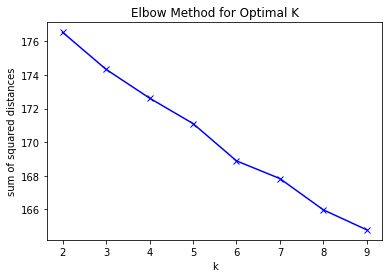

In [6]:
# Create elbow method visualization to get optimum number of cluster

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(data)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for Optimal K')
plt.show()

In [7]:
# Use the optimum number of cluster to build the clustering

k = 9
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data)

KMeans(n_clusters=9, random_state=42)

In [8]:
# Count the occurence of data points for each cluster

clusters = kmeans.labels_
print(Counter(clusters))

Counter({0: 69, 1: 22, 5: 21, 3: 18, 2: 15, 4: 13, 8: 9, 7: 8, 6: 8})


In [9]:
# Try to get to 10 most common words for each cluster along with the cluster number
# and the occurence of data points of each cluster

# Get unique cluster labels
labels = np.unique(clusters)

# Transform vectorized data to array
data_array = data.toarray()

# Create counter for data points of each cluster
counter = Counter(clusters)

data_array.shape

(183, 1135)

In [10]:
# Process one cluster at a time
for label in labels:
#     Print cluster label
    print('Cluster: {}'.format(label + 1))
    print('Data count: {}'.format(counter[label]))
#     Get the index of the data points from the cluster currently being processed
    id_temp = np.where(clusters==label)
#     Get the average tfidf score of every word feature from all data points
    x_means = np.mean(data_array[id_temp], axis = 0) # returns average score across cluster
#     Get sorted index of features based on average score    
    sorted_means = np.argsort(x_means)[::-1][:4]
#     Get feature column names to be incorporated to the results
    features = tfidf_vectorizer.get_feature_names()
#     Get two dimension list of features and their score based on the sorted features
    best_features = [(features[i], x_means[i]) for i in sorted_means]
#     Add column names to the sorted features two-dimentional list
    df = pd.DataFrame(best_features, columns = ['features', 'score'])
    print(df)

Cluster: 1
Data count: 69
      features     score
0      concert  0.036887
1  overcrowded  0.026687
2        dozen  0.023477
3     teenager  0.023335
Cluster: 2
Data count: 22
  features     score
0  stadium  0.277521
1      cup  0.065624
2    match  0.061136
3      fan  0.061130
Cluster: 3
Data count: 15
  features     score
0  stoning  0.177419
1  pilgrim  0.160637
2    devil  0.111215
3    mecca  0.099487
Cluster: 4
Data count: 18
      features     score
0  celebration  0.119563
1          fan  0.109799
2     football  0.103184
3         game  0.093829
Cluster: 5
Data count: 13
   features     score
0  festival  0.183566
1   killing  0.094749
2  injuring  0.083621
3     large  0.073743
Cluster: 6
Data count: 21
    features     score
0      child  0.143528
1      woman  0.092266
2    barrier  0.046682
3  resulting  0.044678
Cluster: 7
Data count: 8
    features     score
0     temple  0.433549
1  stampeded  0.084434
2     indian  0.084248
3      hindu  0.081092
Cluster: 8
Data cou

### Topic Modeling Using Non-negative Matrix Factorization (NMF)

In [11]:
# Instantiate the NMF object and define the number of topics

t = 10
nmf_model = NMF(n_components=t, init='nndsvda', random_state=42)

In [12]:
# Do count vectorizing

count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=None, max_df=0.5, min_df=2)

data_count = count_vectorizer.fit_transform(clean_data)


In [13]:
# Fit the NMF algorithm

nmf_model.fit(data_count)

NMF(init='nndsvda', n_components=10, random_state=42)

In [14]:
# Get the features of the NMF model that is fitted to the data

nmf_transform  = nmf_model.transform(data_count)
nmf_transform.shape

(183, 10)

In [15]:
# Check out the components of the model

nmf_model.components_.shape

(10, 321)

In [16]:
# Create dataframe of features components

nmf_components_df = pd.DataFrame(nmf_model.components_, columns=count_vectorizer.get_feature_names())
nmf_components_df.shape

(10, 321)

In [17]:
# Get frequency of each topic in the data

# Get the maximum topic value of each data points and then count each
nmf_topic_freq = pd.DataFrame(nmf_transform).idxmax(axis=1).value_counts()
nmf_topic_freq

9    31
8    27
0    24
2    20
4    19
5    18
1    15
7    11
3     9
6     9
dtype: int64

In [18]:
# Get top terms for each topic

# Iterate for each topic
for topic in range(nmf_components_df.shape[0]):
#     Locate the topic
    tmp = nmf_components_df.iloc[topic]
    print(f'Topic {topic+1}')
#     Print topic frequency
    print(f'Frequency: {nmf_topic_freq[topic]}')
#     Get the largest 5 words
    print(tmp.nlargest(5))
    print('\n')

Topic 1
Frequency: 24
stadium    3.549128
enter      0.779738
cup        0.721586
match      0.686105
world      0.463494
Name: 0, dtype: float64


Topic 2
Frequency: 15
fan         1.727470
football    0.918356
gas         0.664143
fired       0.543218
disaster    0.505742
Name: 1, dtype: float64


Topic 3
Frequency: 20
pilgrim     2.054816
saudi       0.890397
hajj        0.494517
arabia      0.444419
incident    0.429549
Name: 2, dtype: float64


Topic 4
Frequency: 9
student     1.997339
game        1.679910
football    0.684784
stadium     0.647833
capacity    0.630077
Name: 3, dtype: float64


Topic 5
Frequency: 19
child        2.032182
school       0.658294
stairwell    0.565176
primary      0.472596
pupil        0.433328
Name: 4, dtype: float64


Topic 6
Frequency: 18
club        1.320599
woman       1.196667
said        0.874825
arrested    0.549748
result      0.475791
Name: 5, dtype: float64


Topic 7
Frequency: 9
force       1.147775
security    1.080679
fired       0.823868

### Topic Modeling Using Latent Dirichlet Allocation (LDA)

In [19]:
# Assign number of topics

t = 10

# Instatiate the algorithm and fit the algorithm to count vectorized data

lda_model = LatentDirichletAllocation(n_components=t, learning_method='batch', random_state=42)

lda_model.fit(data_count)

LatentDirichletAllocation(random_state=42)

In [20]:
# Get the features of the NMF model that is fitted to the data

lda_transform  = lda_model.transform(data_count)
lda_transform.shape

(183, 10)

In [21]:
# Check out the components of the model

lda_model.components_.shape

(10, 321)

In [22]:
# Create dataframe of features components

lda_components_df = pd.DataFrame(lda_model.components_, columns=count_vectorizer.get_feature_names())
lda_components_df.shape

(10, 321)

In [23]:
# Get frequency of each topic in the data

# Get the maximum topic value of each data points and then count each
lda_topic_freq = pd.DataFrame(lda_transform).idxmax(axis=1).value_counts()
lda_topic_freq

0    29
8    25
3    21
6    18
1    17
2    17
4    16
5    16
7    14
9    10
dtype: int64

In [31]:
# temp

lda_df = pd.DataFrame(lda_transform).idxmax(axis=1)

0      7
1      0
2      1
3      4
4      4
      ..
178    5
179    9
180    0
181    0
182    3
Length: 183, dtype: int64

In [24]:
# Get top terms for each topic

# Iterate each topic
for topic in range(lda_components_df.shape[0]):
#     Locate the topic
    tmp = lda_components_df.iloc[topic]
    print(f'Topic {topic+1}')
#     Print topic frequency
    print(f'Frequency: {lda_topic_freq[topic]}')
#     Get the largest 5 words
    print(tmp.nlargest(5))
    print('\n')

Topic 1
Frequency: 29
bridge         5.100108
concert        5.100033
dozen          3.100064
celebration    3.100027
stoning        3.099996
Name: 0, dtype: float64


Topic 2
Frequency: 17
student    6.099994
fan        5.100067
game       5.100045
temple     5.100013
concert    3.100049
Name: 1, dtype: float64


Topic 3
Frequency: 17
child       5.100237
stairway    5.075241
city        4.100027
aged        3.099998
escape      3.074537
Name: 2, dtype: float64


Topic 4
Frequency: 21
festival    9.100037
stadium     6.100040
broke       5.099991
dead        3.847981
child       3.100063
Name: 3, dtype: float64


Topic 5
Frequency: 16
pilgrim     6.100196
fired       4.100014
gas         3.911913
canister    3.100001
church      3.100001
Name: 4, dtype: float64


Topic 6
Frequency: 16
exit       3.100057
led        3.100056
church     3.100012
devil      3.100012
stoning    3.100001
Name: 5, dtype: float64


Topic 7
Frequency: 18
stadium    9.100097
concert    4.100029
enter      3.10

In [28]:
lda_transform[1]

array([0.87141738, 0.01428675, 0.01429088, 0.01428618, 0.01428626,
       0.01428571, 0.01428571, 0.01428592, 0.01428722, 0.01428797])